# Summary

We sample from Y and see if we can fit a model back to Y.

In [2]:
from MMBGP.data_generation import ToyBranchedData, GeneExpressionData
from MMBGP.training_helpers import TrainingOutcome, get_training_outcome
from MMBGP.plotting_helpers import plot_detailed_fit, plot_model_snapshot
from MMBGP.sampling_helpers import get_synthetic_noisy_branched_data

from MMBGP.assigngp import AssignGP
from MMBGP.VBHelperFunctions import plotBranchModel
import matplotlib.pyplot as plt
import numpy as np

In [10]:
from MMBGP.training_helpers import (
    construct_assigngp_model, 
    SimplePhiConstructor, 
    ScipyOptimiser, 
    ElvijsAmazingOptimiser,
)
import gpflow
from typing import Sequence


def get_assigngp_with_target_bps(bps: Sequence[float], lengthscale: float, noise_variance: float) -> AssignGP:
    data = ToyBranchedData(bps, N=100)  # not used; need data to construct a model
    m = construct_assigngp_model(
        gene_expression=data,
        phi_constructor=SimplePhiConstructor(data, prior_confidence=0.65),
        initial_branching_points=[0.5]*data.num_genes,
    )
    # assign reasonable initial values for the BPs
    m.kernel.Bv.assign(np.array(bps))
    m.kernel.kern.lengthscales.assign(lengthscale)
    m.likelihood.variance.assign(noise_variance)
    return m


model = get_assigngp_with_target_bps([0.1, 0.5, 0.9], lengthscale=0.5, noise_variance=0.001)
model

name,class,transform,prior,trainable,shape,dtype,value
AssignGP.ZExpanded,Parameter,Identity,,False,"(180, 2)",float64,"[[0., 1...."
AssignGP.kernel.kern.variance,Parameter,Softplus,,True,(),float64,1.0
AssignGP.kernel.kern.lengthscales,Parameter,Softplus,,True,(),float64,0.5
AssignGP.kernel.Bv,Parameter,Sigmoid,,True,"(3,)",float64,[0.1 0.5 0.9]
AssignGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0010000000000000002
AssignGP.logPhi,Parameter,Identity,,True,"(100, 300)",float64,"[[-20.72326584, -0.66220178, -0.72508086..."


In [13]:
bds = get_synthetic_noisy_branched_data(model, num_samples=10, x_pts=100)

Discarding sample 0 due to multiple crossings in gene 0
Discarding sample 0 due to multiple crossings in gene 2
Discarding sample 1 due to multiple crossings in gene 0
Discarding sample 1 due to multiple crossings in gene 1
Discarding sample 2 due to multiple crossings in gene 1
Discarding sample 2 due to multiple crossings in gene 2
Discarding sample 3 due to multiple crossings in gene 2
Discarding sample 4 due to multiple crossings in gene 1
Discarding sample 4 due to multiple crossings in gene 2
Discarding sample 5 due to multiple crossings in gene 0
Discarding sample 5 due to multiple crossings in gene 1
Discarding sample 5 due to multiple crossings in gene 2
Discarding sample 6 due to multiple crossings in gene 0
Discarding sample 7 due to multiple crossings in gene 0
Discarding sample 8 due to multiple crossings in gene 0
Discarding sample 9 due to multiple crossings in gene 1
Discarding sample 9 due to multiple crossings in gene 2
Discarding sample 0 due to multiple crossings in

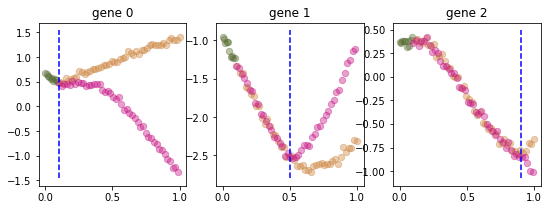

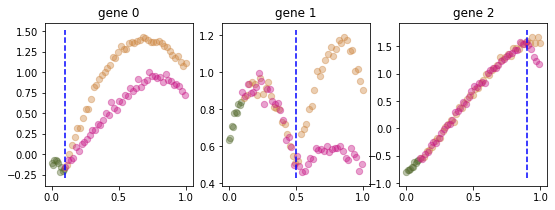

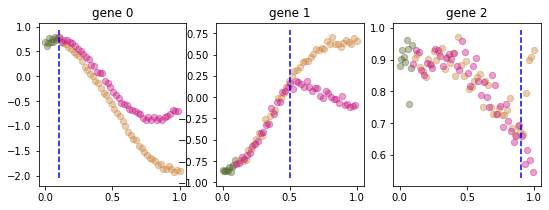

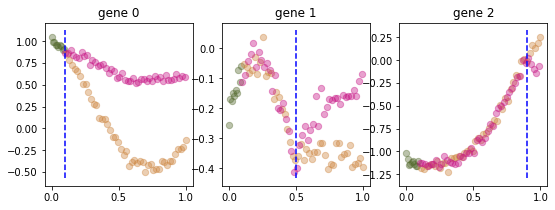

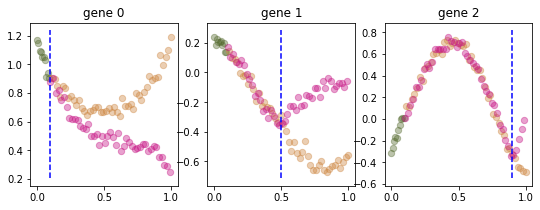

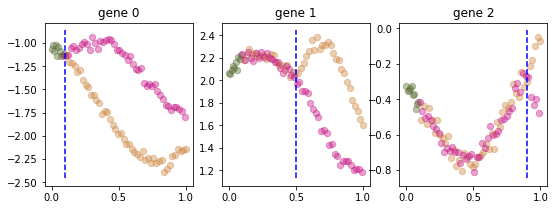

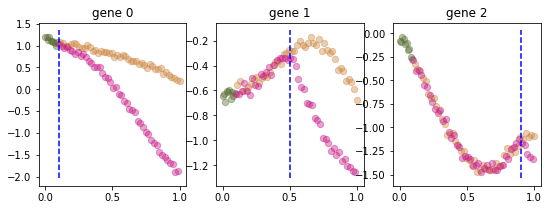

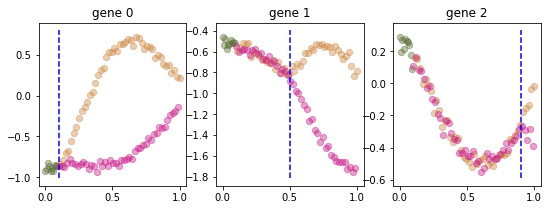

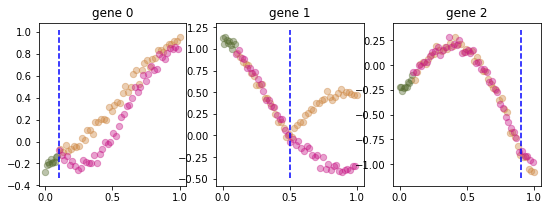

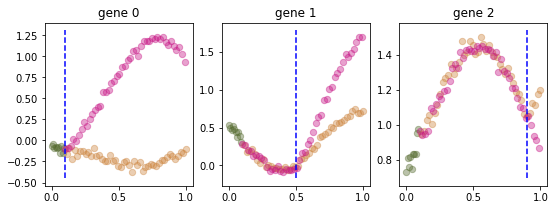

In [14]:
for bd in bds:
    bd.plot()

In [ ]:
from dataclasses import dataclass
from enum import Enum


#
# Experiment setup
#

# Question 5: can the model rediscover early branching? 
#   priorConfidence=0.5 for early cells (say up to pseudotime 0.8). 
#   Can we then rediscover the early cell labels and branching time?

# Suggestion: start with question 5, no param sweeps. 
#   10 samples with a fixed noise level 
#   (we want it as high as possible provided the models don't go pear-shaped. Tune on MMBGP.) 
#   and 10 genes (spot check against 1 gene).
#   Measure RMSE on BPs and label inconsistencies.

# Figure: rows are genes, MMBGP on the left, BGP on the right. Compare per gene.


# Potential future directions

# Question 1: are we faster than BGP? As a function of outputs.
# Question 2: are we as correct as BGP when there is no label corruption?
# Question 3: does MMBGP handle label corruption better than BGP?
# Question 4: what happens as we vary the priorConfidence?

# Deprioritise the cartesian product below.

NUM_SAMPLES = 10  # How many times we re-sample from a given model. Intended for confidence intervals.  
NOISE_LEVELS = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
NUM_GENES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
LABEL_CORRUPTION_LEVEL = [0., 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
# The ratio of cell assignments that are incorrect



# True BPs to be sampled uniformly randomly from [0, 1]

# TODO: double-check that we don't rely on the first dimension having the earliest BP
# TODO: spot-check branched data for all parameter combinations


class Algorithm:
    """ Algorithms we will use in this study. """
    MMBGP = "MMBGP"
    BGP = "BGP"


@dataclass
class Result:
    """ Metrics we collect for each experiment. """
    rmse: float  # RMSE between true bps and learned bps
    l1: float  # |true_bps - learned_bps|
    linf: float  # max_i {|true_bps_i - learned_bps_i|}
    
    training_time_in_s: float  # How long did it take to train this model?
    
    trained_model: AssignGP
    
    algorithm: Algorithm



